In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from PIL import Image
import requests
from io import BytesIO
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras.callbacks import LearningRateScheduler
import string
import gensim
from gensim.models.word2vec import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Tidying up data
1) Removed features that are unrelated to the card prices, such as the number and id.
2) Removed features that are repeated (such as pend_desc and monster_desc, both of which are already included in desc, also type, which overlaps with frameType.
3) Dropped some rows with missing information, such as some rows from card_sets.
4) filled empty cells with 0, as all the values are intentionally missing due to the properties of the cards (e.g. Spell and Trap cards do not have Attack and Defence points).
5) split up nested cells into multiple columns, such as card_sets and card_prices, which contain multivariate features but are shown in only 1 single cell.

In [2]:
import ast
import os

import os
card_df=pd.read_csv('card_data.csv')

# filepath='./artwork/artwork'
# dirlist=os.listdir(filepath)
# for i in card_df['id']:
#     imgpath='{}.jpg'.format(i)
#     if imgpath in dirlist:       
#         card_df[card_df['id']==i]['card_image']=plt.imread(os.path.join(filepath,imgpath))
#     else:
#         card_df[card_df['id']==i]['card_image']=0




#drop all empty card sets
card_df=card_df.dropna(subset='card_sets')
# card_df = card_df.sample(n=2000), random_state=42)

# Remove descriptions for Normal monsters
card_df['desc']=[card_df['desc'].iloc[x] if (card_df['type'].iloc[x]!='Normal Monster') else '' for x in range(len(card_df)) ]
card_df['cardlength']=[len(x) for x in card_df['desc']]

#seperate card sets into individual columns
temp=[ast.literal_eval(x) for x in card_df['card_sets'].values]
card_df['reprints']=[len(temp[x]) for x in range(len(temp))]
card_df['set_name']=[temp[x][0]['set_name'] for x in range(len(temp))]
card_df['set_rarity']=[temp[x][0]['set_rarity'] for x in range(len(temp))]
card_df['set_rarity_code']=[temp[x][0]['set_rarity_code'] for x in range(len(temp))]
card_df['set_price']=[temp[x][0]['set_price'] for x in range(len(temp))]
card_df=card_df.drop(['card_sets'],axis=1)

#seperate card images into individual columns
card_images=[ast.literal_eval(x) for x in card_df['card_images'].values]
image_url=[card_images[x][0]['image_url'] for x in range(len(card_images))]
image_url_small=[card_images[x][0]['image_url_small'] for x in range(len(card_images))]
image_url_cropped=[card_images[x][0]['image_url_cropped'] for x in range(len(card_images))]

#obtain images through the urls obtained
# dispimages=[Image.open(BytesIO(requests.get(x).content)) for x in image_url]
# card_df['card_images']=dispimages

#seperate card prices into individual columns
temp=[ast.literal_eval(x) for x in card_df['card_prices'].values]
card_df['cardmarket_price']=[temp[x][0]['cardmarket_price'] for x in range(len(temp))]
card_df['tcgplayer_price']=[temp[x][0]['tcgplayer_price'] for x in range(len(temp))]
card_df['ebay_price']=[temp[x][0]['ebay_price'] for x in range(len(temp))]
card_df['amazon_price']=[temp[x][0]['amazon_price'] for x in range(len(temp))]
card_df['coolstuffinc_price']=[temp[x][0]['coolstuffinc_price'] for x in range(len(temp))]
card_df=card_df.drop(['card_prices'],axis=1)

#drop unwanted columns
carddesc=card_df['desc']
card_df=card_df.drop(['card_images'],axis=1)
card_df=card_df.drop(['Unnamed: 0','id','frameType','pend_desc','monster_desc','desc','set_rarity_code','linkmarkers'],axis=1)

card_df=card_df.fillna(0)

card_df.head(5)

,name,type,race,archetype,atk,def,level,attribute,scale,linkval,...,cardlength,reprints,set_name,set_rarity,set_price,cardmarket_price,tcgplayer_price,ebay_price,amazon_price,coolstuffinc_price
0,"""A"" Cell Breeding Device",Spell Card,Continuous,Alien,0.0,0.0,0.0,0,0.0,0.0,...,96,1,Force of the Breaker,Common,1.31,0.10,0.19,0.99,24.45,0.25
1,"""A"" Cell Incubator",Spell Card,Continuous,Alien,0.0,0.0,0.0,0,0.0,0.0,...,188,1,Gladiator's Assault,Common,2.1,0.07,0.24,1.25,0.50,0.25
2,"""A"" Cell Recombination Device",Spell Card,Quick-Play,Alien,0.0,0.0,0.0,0,0.0,0.0,...,356,1,Invasion: Vengeance,Common,1.12,0.10,0.20,0.99,0.50,0.49
3,"""A"" Cell Scatter Burst",Spell Card,Quick-Play,Alien,0.0,0.0,0.0,0,0.0,0.0,...,145,1,Strike of Neos,Common,1.13,0.12,0.10,2.00,9.76,0.25
4,"""Infernoble Arms - Almace""",Spell Card,Equip,Noble Knight,0.0,0.0,0.0,0,0.0,0.0,...,476,2,Duelist Nexus,Quarter Century Secret Rare,0,0.00,0.64,0.00,0.00,0.00


In [3]:
card_df_val=card_df
# card_df_val=card_df_val.drop(['linkval'],axis=1)
dict_type=dict(enumerate(card_df.type.astype('category').cat.categories))
card_df_val.type=card_df_val.type.astype('category').cat.codes

card_df_val.race=card_df_val.race.astype('category').cat.codes
dict_race=dict(enumerate(card_df.race.astype('category').cat.categories))
card_df_val.archetype=card_df_val.archetype.astype('category').cat.codes
dict_archetype=dict(enumerate(card_df.archetype.astype('category').cat.categories))
card_df_val.banlist_info=card_df_val.banlist_info.astype('category').cat.codes
dict_banlist_info=dict(enumerate(card_df.banlist_info.astype('category').cat.categories))
card_df_val.attribute=card_df_val.attribute.astype('category').cat.codes
dict_attribute=dict(enumerate(card_df.attribute.astype('category').cat.categories))
card_df_val.set_name=card_df_val.set_name.astype('category').cat.codes
dict_set_name=dict(enumerate(card_df.set_name.astype('category').cat.categories))
card_df_val.set_rarity=card_df_val.sort_values(by=['set_rarity']).set_rarity.astype('category').cat.codes

card_df.head(5)
# print(card_df_val.coef_)
# card_df_val['set_price']

,name,type,race,archetype,atk,def,level,attribute,scale,linkval,...,cardlength,reprints,set_name,set_rarity,set_price,cardmarket_price,tcgplayer_price,ebay_price,amazon_price,coolstuffinc_price
0,"""A"" Cell Breeding Device",16,18,14,0.0,0.0,0.0,0,0.0,0.0,...,96,1,195,2,1.31,0.10,0.19,0.99,24.45,0.25
1,"""A"" Cell Incubator",16,18,14,0.0,0.0,0.0,0,0.0,0.0,...,188,1,206,2,2.1,0.07,0.24,1.25,0.50,0.25
2,"""A"" Cell Recombination Device",16,59,14,0.0,0.0,0.0,0,0.0,0.0,...,356,1,217,2,1.12,0.10,0.20,0.99,0.50,0.49
3,"""A"" Cell Scatter Burst",16,59,14,0.0,0.0,0.0,0,0.0,0.0,...,145,1,403,2,1.13,0.12,0.10,2.00,9.76,0.25
4,"""Infernoble Arms - Almace""",16,28,318,0.0,0.0,0.0,0,0.0,0.0,...,476,2,160,19,0,0.00,0.64,0.00,0.00,0.00


In [4]:
card_df_val.describe()

,type,race,archetype,atk,def,level,attribute,scale,linkval,banlist_info,cardlength,reprints,set_name,set_rarity
count,12374.000000,12374.000000,12374.000000,12374.000000,12374.000000,12374.000000,12374.000000,12374.000000,12374.000000,12374.000000,12374.000000,12374.000000,12374.000000,12374.000000
mean,10.200016,44.891789,144.009940,964.521578,773.945369,2.832229,2.338209,0.117181,0.074269,0.276144,290.502263,2.877323,147.767739,13.642638
std,9.778390,20.822593,162.484927,1043.609438,916.361246,2.923383,2.374662,0.859954,0.449929,2.103662,161.612347,2.926368,127.718991,11.739748
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,159.000000,1.000000,30.000000,2.000000
50%,8.000000,52.000000,73.000000,700.000000,300.000000,3.000000,1.000000,0.000000,0.000000,0.000000,282.000000,2.000000,116.000000,16.000000
75%,18.000000,59.000000,280.000000,1800.000000,1500.000000,4.000000,5.000000,0.000000,0.000000,0.000000,418.000000,3.000000,232.000000,27.000000
max,27.000000,85.000000,494.000000,5000.000000,5000.000000,13.000000,7.000000,13.000000,6.000000,25.000000,1400.000000,61.000000,484.000000,31.000000


array([[<Axes: title={'center': 'type'}>,
        <Axes: title={'center': 'race'}>,
        <Axes: title={'center': 'archetype'}>,
        <Axes: title={'center': 'atk'}>],
       [<Axes: title={'center': 'def'}>,
        <Axes: title={'center': 'level'}>,
        <Axes: title={'center': 'attribute'}>,
        <Axes: title={'center': 'scale'}>],
       [<Axes: title={'center': 'linkval'}>,
        <Axes: title={'center': 'banlist_info'}>,
        <Axes: title={'center': 'cardlength'}>,
        <Axes: title={'center': 'reprints'}>],
       [<Axes: title={'center': 'set_name'}>,
        <Axes: title={'center': 'set_rarity'}>, <Axes: >, <Axes: >]],
      dtype=object)

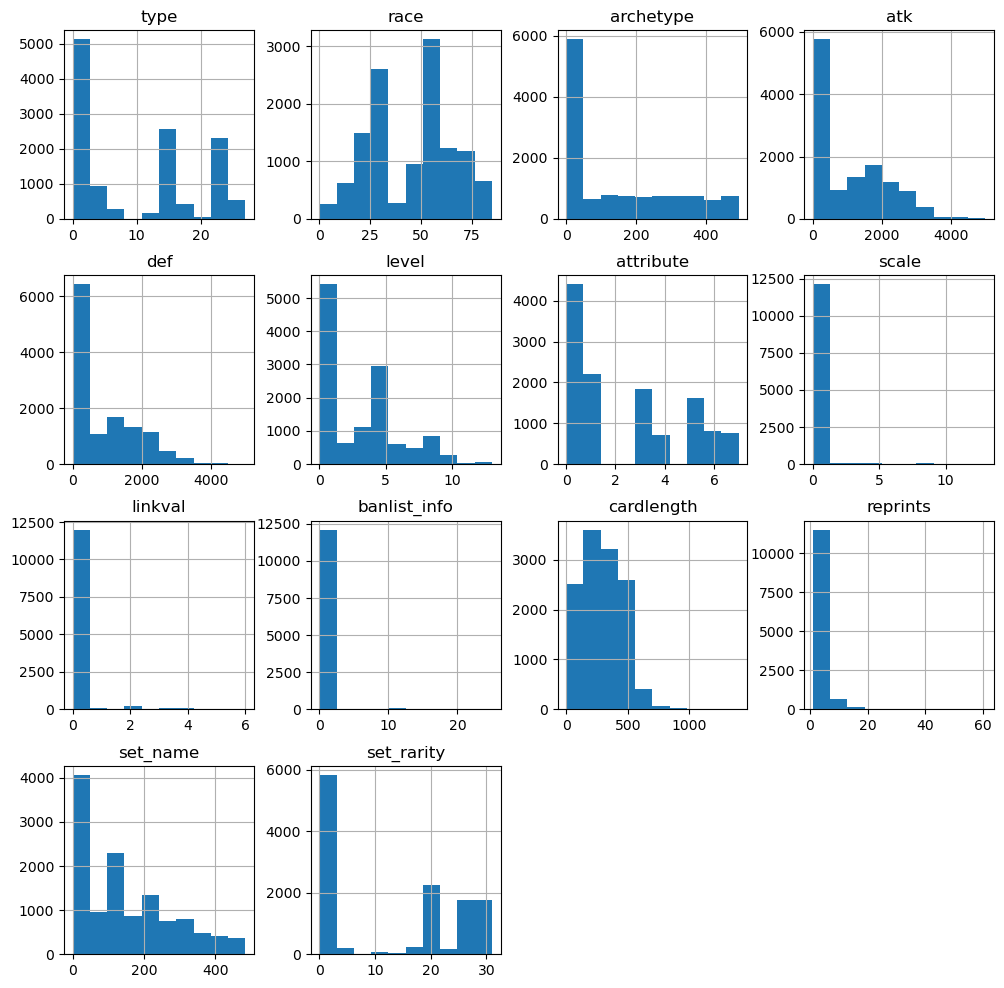

In [5]:
card_df_val.hist(figsize=(12,12))


array([[<Axes: title={'center': 'type'}>,
        <Axes: title={'center': 'race'}>,
        <Axes: title={'center': 'archetype'}>,
        <Axes: title={'center': 'atk'}>],
       [<Axes: title={'center': 'def'}>,
        <Axes: title={'center': 'level'}>,
        <Axes: title={'center': 'attribute'}>,
        <Axes: title={'center': 'scale'}>],
       [<Axes: title={'center': 'linkval'}>,
        <Axes: title={'center': 'banlist_info'}>,
        <Axes: title={'center': 'cardlength'}>,
        <Axes: title={'center': 'reprints'}>],
       [<Axes: title={'center': 'set_name'}>,
        <Axes: title={'center': 'set_rarity'}>,
        <Axes: title={'center': 'set_price'}>, <Axes: >]], dtype=object)

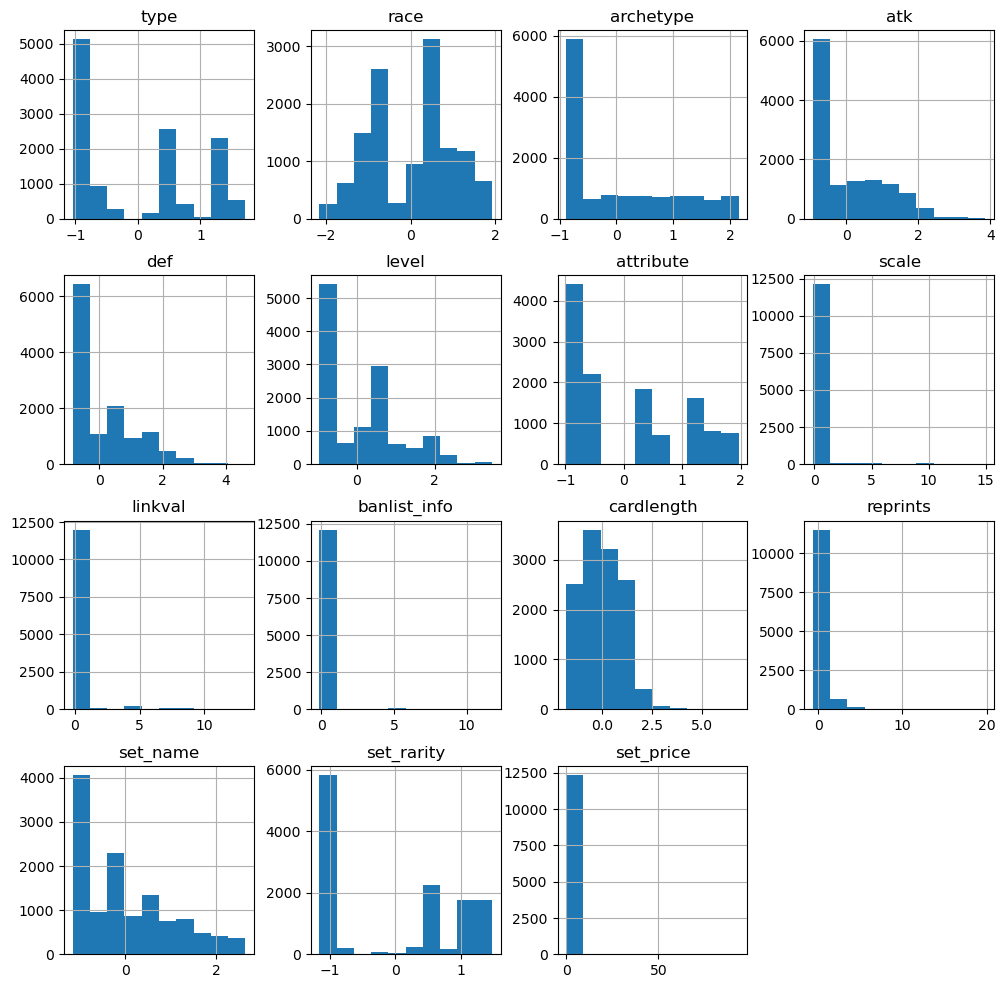

In [6]:
#Standardisation

scaler = StandardScaler()
columns=card_df.iloc[:,1:16].columns
X=card_df_val.iloc[:,1:16].to_numpy()
y=card_df_val.iloc[:,16].to_numpy()
X=np.double(X)
y=np.double(y)
# y=np.average(np.double(y),axis=1)
# print(y[0])

X_scaled = scaler.fit_transform(X)
# print(X.shape)
X_df=pd.DataFrame(X_scaled,columns=columns)
X_df.hist(figsize=(12,12))
# X_scaled[0]
# card_df_val.head

# Correlation Chart

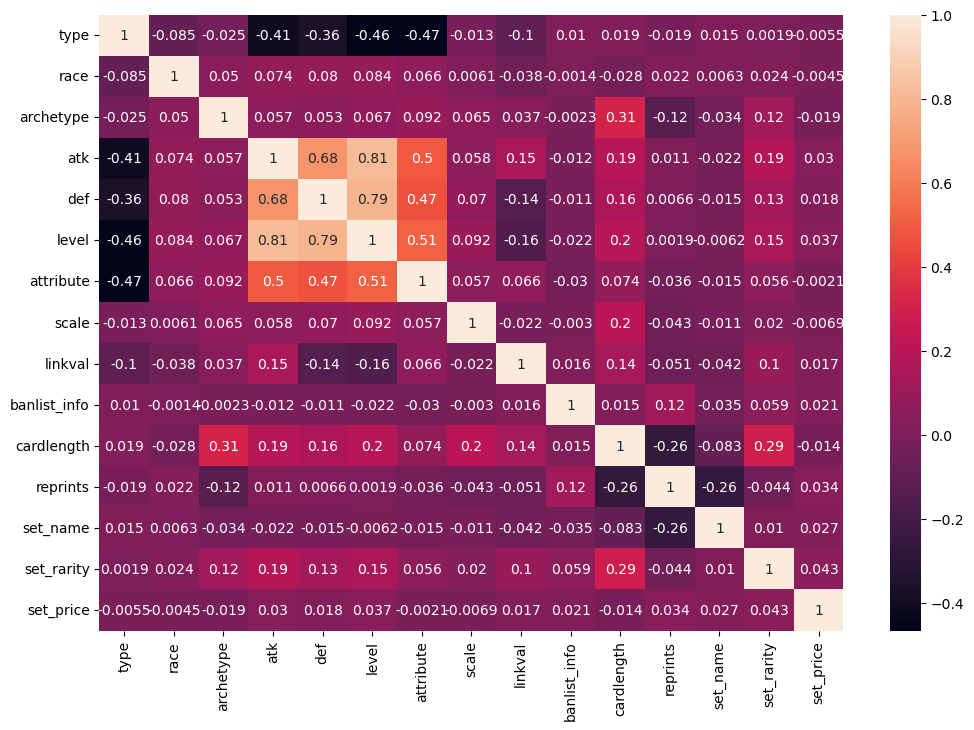

In [7]:
plt.figure(figsize=(12,8))
card_cor = card_df_val.iloc[:,1:16].corr()
sns.heatmap(card_cor, annot=True)
plt.show()

# NLP

In [8]:
carddesc_nopunc = [x.translate(str.maketrans('','',string.punctuation)) for x in carddesc]
method_tfidf = TfidfVectorizer(stop_words='english')
carddesc_tfidf=method_tfidf.fit_transform(carddesc_nopunc).toarray()

In [9]:
print(method_tfidf.vocabulary_) #dictionary
# print(method_tfidf.vocabulary_)

{'standby': 5712, 'phases': 4460, 'acounter': 196, 'faceup': 2202, 'monster': 3924, 'opponent': 4244, 'controls': 1348, 'time': 6061, 'acounters': 197, 'removed': 4928, 'play': 4531, 'card': 1043, 'effect': 1995, 'place': 4509, 'destroyed': 1642, 'distribute': 1741, 'monsters': 3925, 'target': 5958, 'field': 2276, 'send': 5310, 'alien': 301, 'deck': 1560, 'graveyard': 2675, 'equal': 2093, 'level': 3405, 'sent': 5318, 'main': 3620, 'phase': 4459, 'turn': 6229, 'banish': 642, 'add': 217, 'hand': 2780, 'select': 5301, 'control': 1343, 'destroy': 1641, 'new': 4077, 'opponents': 4245, 'equipped': 2099, 'equip': 2097, 'infernoble': 3056, 'arms': 484, 'spell': 5628, 'gy': 2748, 'appropriate': 416, 'almace': 315, 'warrior': 6488, 'banished': 643, 'use': 6339, 'lower': 3516, 'special': 5615, 'summon': 5828, 'rest': 4991, 'durendal': 1950, 'declare': 1564, 'attacks': 563, 'gains': 2465, 'ability': 151, 'make': 3630, 'second': 5281, 'attack': 556, 'battle': 681, 'hauteclere': 2817, 'joyeuse': 317

In [10]:
print('The shape of the TFIDF array is {}'.format(carddesc_tfidf.shape))

The shape of the TFIDF array is (12374, 6751)


In [11]:
seed=42
X_train_nlp,X_test_nlp,y_train_nlp,y_test_nlp=train_test_split(carddesc_tfidf, y, test_size=0.20, random_state=seed, shuffle=True)
X_test_nlp,X_valid_nlp,y_test_nlp,y_valid_nlp=train_test_split(X_test_nlp,y_test_nlp,test_size=0.50,random_state=seed, shuffle=True)

In [12]:
svm_model_nlp = SVR(C=20).fit(X_train_nlp, y_train_nlp)

ypred_svr_nlp = svm_model_nlp.predict(X_test_nlp)
# print('RMSE:', (metrics.mean_squared_error(y_test, ypred_svr)))
print('coefficient of determination for testing phase', svm_model_nlp.score(X_test_nlp,y_test_nlp))
comparision_df_svr_nlp=pd.DataFrame({'Actual':y_test_nlp,'Pred':ypred_svr_nlp})

print('R2 testing:', metrics.r2_score(y_test_nlp,ypred_svr_nlp))
print('RMSE testing:', np.sqrt(metrics.mean_squared_error(y_test_nlp, ypred_svr_nlp)))
# beta=svm_model.dual_coef_
# plt.barh(columns,beta)
ypred_svr_valid_nlp = svm_model_nlp.predict(X_valid_nlp)
# print('RMSE:', (metrics.mean_squared_error(y_test, ypred_svr)))
print('R2 valid:', metrics.r2_score(y_valid_nlp,ypred_svr_valid_nlp))
print('coefficient of determination for validation phase', svm_model_nlp.score(X_valid_nlp,y_valid_nlp))
comparision_df_svr_valid_nlp=pd.DataFrame({'Actual':y_valid_nlp,'Pred':ypred_svr_valid_nlp})


print('RMSE validation:', np.sqrt(metrics.mean_squared_error(y_valid_nlp, ypred_svr_valid_nlp)))

coefficient of determination for testing phase -0.040055358857163936
R2 testing: -0.040055358857163936
RMSE testing: 2.9107920938154437
R2 valid: 0.0077763934379867505
coefficient of determination for validation phase 0.0077763934379867505
RMSE validation: 9.16735568019731


<Axes: ylabel='Frequency'>

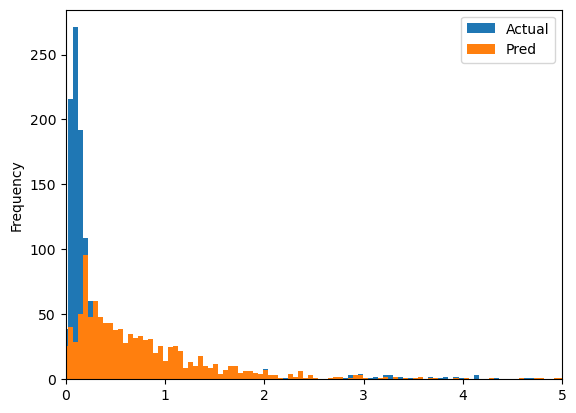

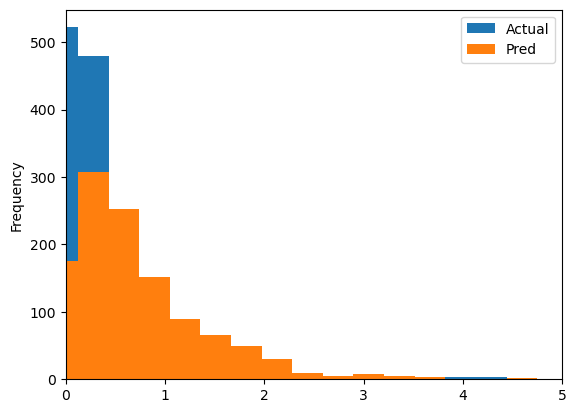

In [13]:
comparision_df_svr_nlp.plot(kind='hist',bins=1000,xlim=(0,5))
comparision_df_svr_valid_nlp.plot(kind='hist',bins=1000,xlim=(0,5))

In [ ]:
def scheduler(epoch, lr):
    if epoch % 100:
        return lr
    else:
        return lr * 0.1

callback = keras.callbacks.LearningRateScheduler(scheduler)
D1=2048
D2=1024
lr=1e-5
D3=512
my_nn_nlp=Sequential()
my_nn_nlp.add(Dense(D1,input_dim=X_train_nlp.shape[1]))
# my_nn.add(Dropout(0.1))
my_nn_nlp.add(BatchNormalization())
my_nn_nlp.add(Dense(D2,input_dim=D1,activation='relu'))
# my_nn.add(Dropout(0.1))
my_nn_nlp.add(Dense(D3,input_dim=D2,activation='relu'))
# my_nn.add(Dropout(0.1))
my_nn_nlp.add(BatchNormalization())
my_nn_nlp.add(Dense(1,input_dim=D3)) #Output shape is 1 because we're doing regression
print(my_nn_nlp.summary())
opt=keras.optimizers.Adam(learning_rate=lr)
my_nn_nlp.compile(loss='mean_squared_error', optimizer='adam')
my_nn_nlp.fit(X_train_nlp,y_train_nlp,verbose=1,epochs=100)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              13828096  
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 1)                 5

In [ ]:
y_pred_nn_nlp = my_nn_nlp.predict(X_test_nlp)
y_pred_nn_nlp_true = y_pred_nn_nlp[:,0]
# Measure RMSE error.  
score_nlp = metrics.r2_score(y_test_nlp,y_pred_nn_nlp_true)
print("Final score (R2): {}".format(metrics.r2_score(y_test_nlp,y_pred_nn_nlp_true)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_test_nlp,y_pred_nn_nlp_true))))
print(y_pred_nn_nlp_true.shape)
print(y_test_nlp.shape)
comparision_df_nn_nlp=pd.DataFrame({'Actual':y_test_nlp,'Pred':y_pred_nn_nlp_true})
comparision_df_nn_nlp.head()

# Random Forest for NLP

In [ ]:
rf_nlp=RandomForestRegressor(n_estimators=50)
rf_nlp.fit(X_train_nlp,y_train_nlp)
ypred_rf_nlp=rf_nlp.predict(X_test_nlp)

# score_rf_nlp = metrics.r2_score(y_test_nlp,ypred_rf_nlp)
print("Final score (R2): {}".format(metrics.r2_score(y_test_nlp,ypred_rf_nlp)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_test_nlp,ypred_rf_nlp))))
print(ypred_rf_nlp.shape)
print(y_test_nlp.shape)
comparision_df_rf_nn_nlp=pd.DataFrame({'Actual':y_test_nlp,'Pred':ypred_rf_nlp})
comparision_df_rf_nn_nlp.head()

# Feature Selection

## Random Forest Regressor

In [ ]:
forestreg=RandomForestRegressor(n_estimators=50,random_state=seed)
forestreg.fit(X,y)

gamma=forestreg.feature_importances_
plt.barh(columns,gamma)

In [ ]:
#Remove unwanted features
X_filtered=X[:,gamma>0.05]
columns_filtered=columns[gamma>0.05]
print('number of columns after feature selection is: {}'.format(len(columns_filtered)))

# Split train and test set

In [ ]:
#split the dataset, random_state for replication
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.20, random_state=seed, shuffle=True) 
X_test,X_valid,y_test,y_valid=train_test_split(X_test,y_test,test_size=0.50,random_state=seed, shuffle=True)

# Linear Regression (BASELINE)

In [ ]:
linreg_model = LinearRegression()
linreg_model.fit(X_train,y_train)
ypred_linreg=linreg_model.predict(X_test)
beta=linreg_model.coef_
# print(features)
# print(columns)
# print(features.shape)
plt.barh(columns_filtered,beta)

# Comparision (Linear Regression)

In [ ]:
comparision_df_linreg=pd.DataFrame({'Actual':y_test,'Pred':ypred_linreg})

print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ypred_linreg)))
comparision_df_linreg.head(25)

In [ ]:
comparision_df_linreg.plot(kind='hist',bins=1000,xlim=(-5,5))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ypred_linreg)))
# comparision_df_linreg['Actual']

In [ ]:
forestreg=RandomForestRegressor(n_estimators=100,random_state=seed)
forestreg.fit(X_filtered,y)

gamma=forestreg.feature_importances_
plt.barh(columns_filtered,gamma)

In [ ]:
ypred_forestreg=forestreg.predict(X_test)
comparision_df_forestreg=pd.DataFrame({'Actual':y_test,'Pred':ypred_forestreg})

print('R2 score:', metrics.r2_score(y_test, ypred_forestreg))
print('RMSE score:', np.sqrt(metrics.mean_squared_error(y_test, ypred_forestreg)))
# comparision_df_forestreg.head(25)

ypred_forestreg_valid=forestreg.predict(X_valid)
comparision_df_forestreg_valid=pd.DataFrame({'Actual':y_valid,'Pred':ypred_forestreg_valid})


print('R2 score:', metrics.r2_score(y_valid, ypred_forestreg_valid))
print('RMSE score:', np.sqrt(metrics.mean_squared_error(y_valid, ypred_forestreg_valid)))
comparision_df_forestreg_valid.head(25)

In [ ]:
comparision_df_forestreg.plot(kind='hist',bins=1000,xlim=(0,5))
comparision_df_forestreg_valid.plot(kind='hist',bins=1000,xlim=(0,5))
# comparision_df_linreg['Actual']

# Decision Tree

In [ ]:
tree1 = DecisionTreeRegressor(max_depth=200, random_state=seed)
tree2 = DecisionTreeRegressor(max_depth=500, random_state=seed)
tree1.fit(X_train, y_train)
tree2.fit(X_train, y_train)

ypred_tree1=tree1.predict(X_test)
ypred_tree2=tree2.predict(X_test)

comparision_df_tree1=pd.DataFrame({'Actual':y_test,'Pred':ypred_tree1})
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ypred_tree1)))
print('R2 score:', metrics.r2_score(y_test, ypred_tree1))
comparision_df_tree2=pd.DataFrame({'Actual':y_test,'Pred':ypred_tree2})
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ypred_tree2)))
print('R2 score:', metrics.r2_score(y_test, ypred_tree2))

comparision_df_tree1.head(25)

In [ ]:
comparision_df_tree1.plot(kind='hist',bins=1000,xlim=(0,5))
comparision_df_tree2.plot(kind='hist',bins=1000,xlim=(0,5))

# SVR

In [ ]:
svm_model = SVR(C=50).fit(X_train, y_train)

ypred_svr = svm_model.predict(X_test)
# print('RMSE:', (metrics.mean_squared_error(y_test, ypred_svr)))
print('coefficient of determination for testing phase', svm_model.score(X_test,y_test))
comparision_df_svr=pd.DataFrame({'Actual':y_test,'Pred':ypred_svr})

print('R2 score:', metrics.r2_score(y_test, ypred_svr))
print('RMSE testing:', np.sqrt(metrics.mean_squared_error(y_test, ypred_svr)))
# beta=svm_model.dual_coef_
# plt.barh(columns,beta)
ypred_svr_valid = svm_model.predict(X_valid)
# print('RMSE:', (metrics.mean_squared_error(y_test, ypred_svr)))

print('coefficient of determination for validation phase', svm_model.score(X_valid,y_valid))
comparision_df_svr_valid=pd.DataFrame({'Actual':y_valid,'Pred':ypred_svr_valid})

print('R2 score:', metrics.r2_score(y_valid, ypred_svr_valid))
print('RMSE validation:', np.sqrt(metrics.mean_squared_error(y_valid, ypred_svr_valid)))

In [ ]:
comparision_df_svr.plot(kind='hist',bins=1000,xlim=(0,3))
comparision_df_svr_valid.plot(kind='hist',bins=1000,xlim=(0,3))

# Neural Networks

In [ ]:
def scheduler(epoch, lr):
    if epoch % 25:
        return lr 
    else:
        return lr *0.99

callback = keras.callbacks.LearningRateScheduler(scheduler)
D1=1024
D2=512
lr=1e-5
D3=256
my_nn=Sequential()
my_nn.add(Dense(D1,input_dim=X_filtered.shape[1]))
# my_nn.add(Dropout(0.1))
my_nn.add(BatchNormalization())
my_nn.add(Dense(D2,input_dim=D1,activation='relu'))
# my_nn.add(Dropout(0.1))
my_nn.add(BatchNormalization())
my_nn.add(Dense(D3,input_dim=D2,activation='relu'))
# my_nn.add(Dropout(0.1))
my_nn.add(BatchNormalization())
my_nn.add(Dense(1,input_dim=D3)) #Output shape is 1 because we're doing regression
print(my_nn.summary())
opt=keras.optimizers.Adam(learning_rate=lr)
my_nn.compile(loss='mean_squared_error', optimizer='adam')
my_nn.fit(X_train,y_train,verbose=1,epochs=200, callbacks=[callback])

In [ ]:
y_pred_nn = my_nn.predict(X_test)
y_pred_nn_true = y_pred_nn[:,0]
# Measure RMSE error.  
print("Final score (R2): {}".format(metrics.r2_score(y_test,y_pred_nn_true)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_test,y_pred_nn_true))))
print(y_pred_nn_true.shape)
print(y_test.shape)
comparision_df_nn=pd.DataFrame({'Actual':y_test,'Pred':y_pred_nn_true})
comparision_df_nn[comparision_df_nn.Pred>0]

In [ ]:
comparision_df_nn.plot(kind='hist',bins=2000,xlim=(0,3))
plt.show()